In [102]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as stats

import statsmodels.api as sma
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error,mean_absolute_percentage_error

import warnings
warnings.filterwarnings('ignore')

In [103]:
# Read The dataset

data = pd.read_excel('Concrete_Data.xls')

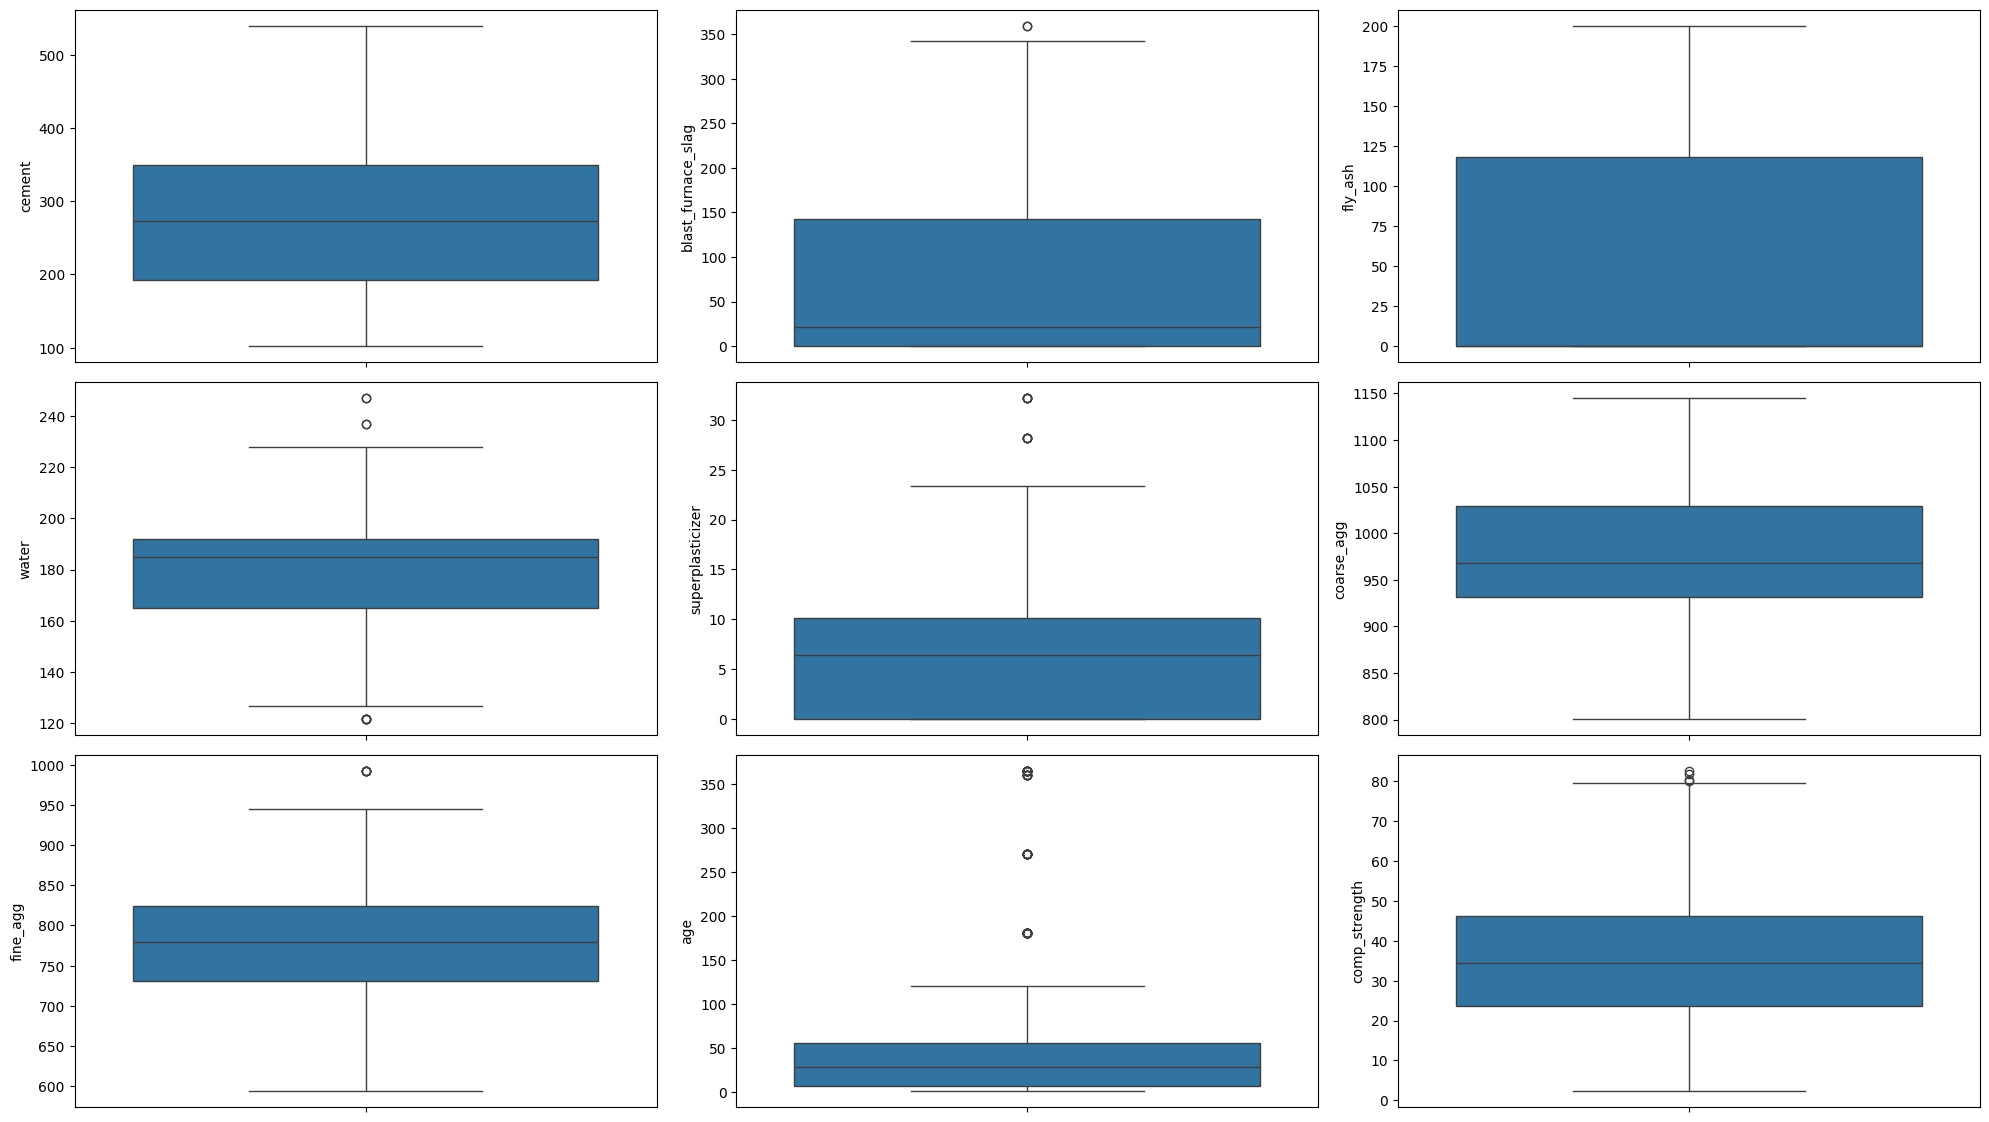

In [104]:
t=1
plt.figure(figsize=[20,15])
for i in data.columns:
    plt.subplot(4,3,t)
    sns.boxplot(data[i])
    t=t+1
plt.tight_layout()

In [105]:
# Calculate the quantiles
q95 = data.quantile(0.850)
q05 = data.quantile(0.15)

# Cap the values above the 95th percentile and below the 5th percentile
data= data.clip(q05, q95, axis=1)

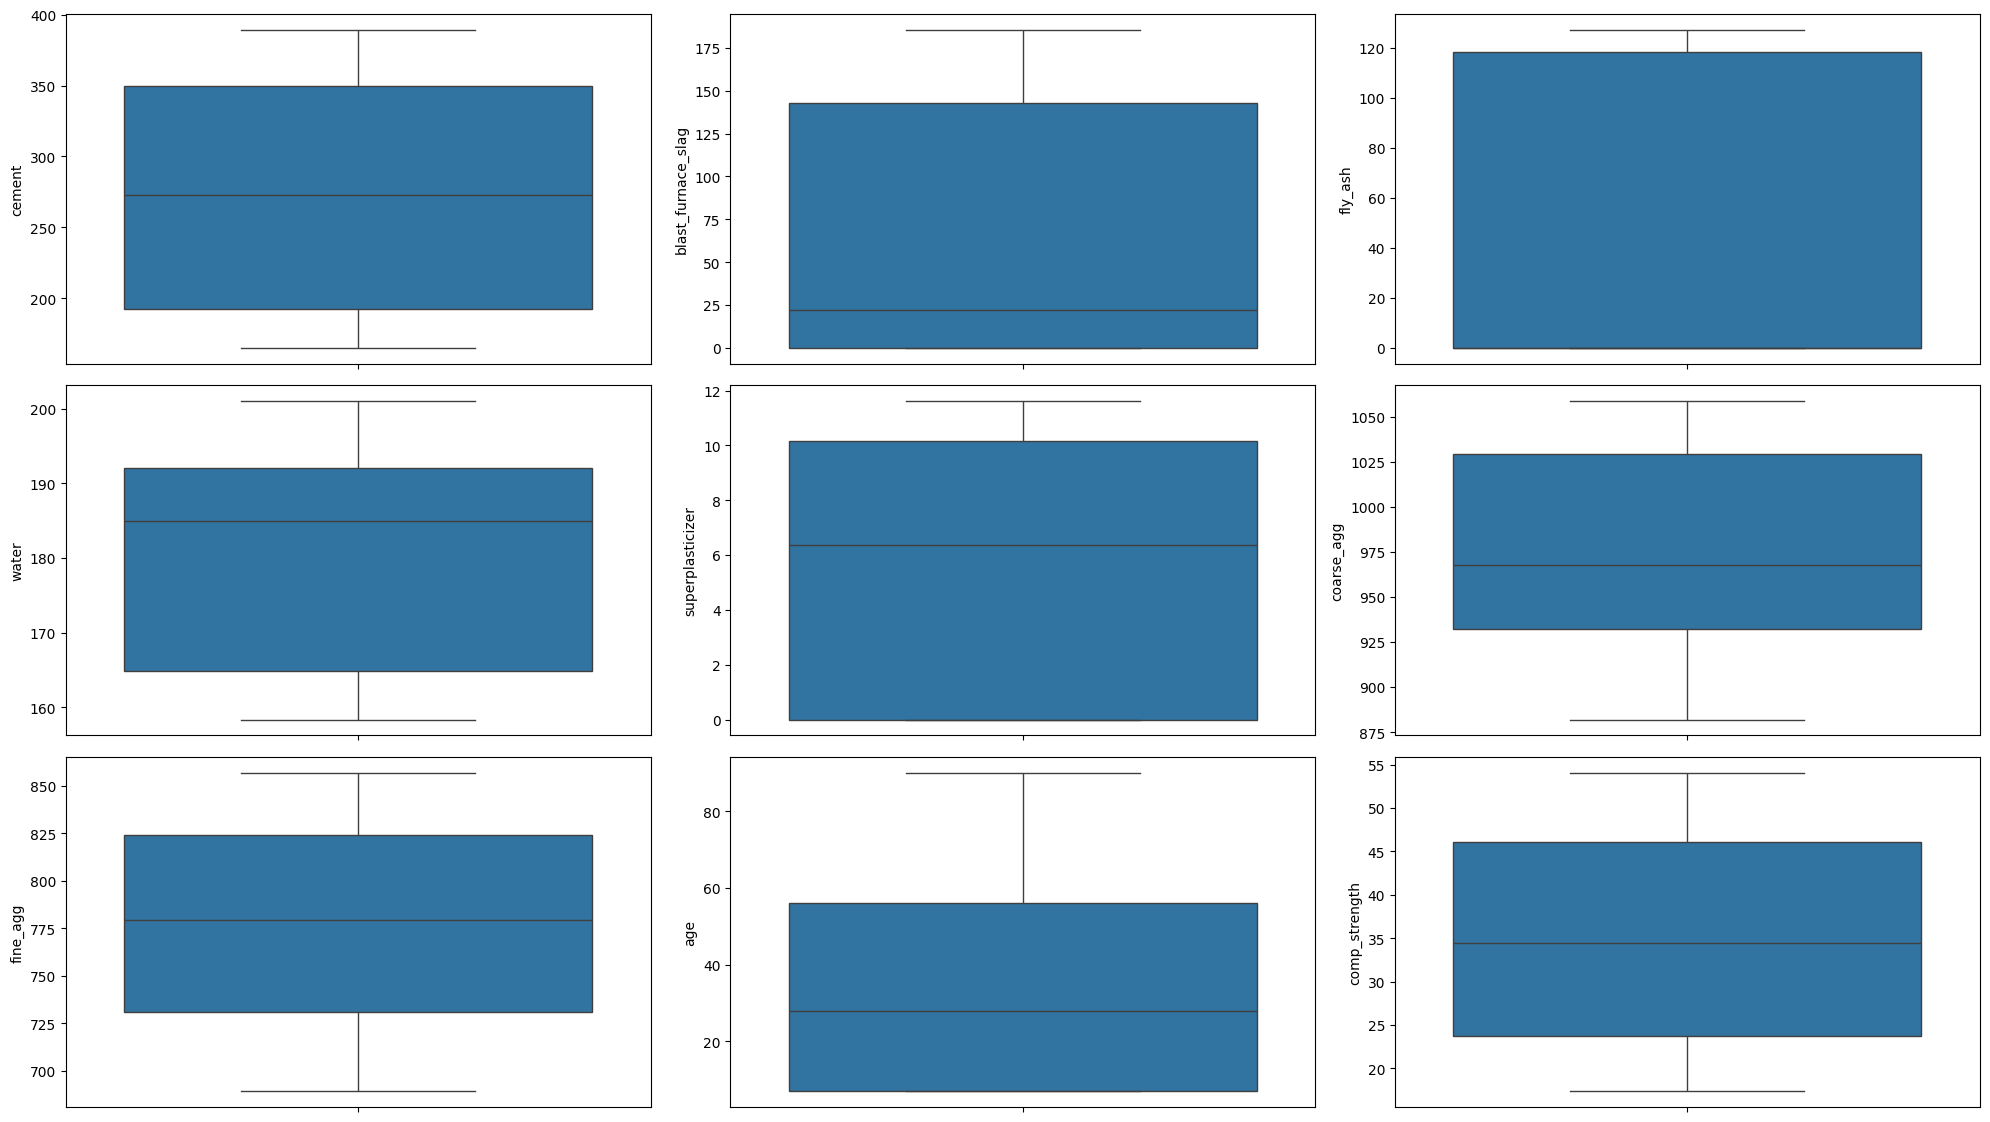

In [106]:
t=1
plt.figure(figsize=[20,15])
for i in data.columns:
    plt.subplot(4,3,t)
    sns.boxplot(data[i])
    t=t+1
plt.tight_layout()

In [107]:
data.head()

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_agg,fine_agg,age,comp_strength
0,389.445,0.0,0.0,162.0,2.5,1040.0,689.3,28,54.048024
1,389.445,0.0,0.0,162.0,2.5,1055.0,689.3,28,54.048024
2,332.500,142.5,0.0,201.0,0.0,932.0,689.3,90,40.269535
3,332.500,142.5,0.0,201.0,0.0,932.0,689.3,90,41.052780
4,198.600,132.4,0.0,192.0,0.0,978.4,825.5,90,44.296075


In [108]:
R1=data['cement'].median()/data['water'].median()
R2=data['cement'].median()/data['coarse_agg'].median()
R3=data['cement'].median()/data['fine_agg'].median()
C = 1+R1+R2+R3
data['Ideal']= C* data['cement']
data['Actual']= data['cement']+data['water']+data['coarse_agg']+data['fine_agg']

In [109]:
data['Z']=(-data['Ideal'] +data['Actual'])/data['Ideal']

In [110]:
stats.norm.pdf(data['Z'])

array([0.26971569, 0.26675306, 0.22128174, ..., 0.00499609, 0.00294402,
       0.11151355])

In [148]:
# Model without outliers present in the dataset
x = data.drop(columns=['comp_strength','water','cement','coarse_agg','fine_agg','Ideal','Actual'])
y = data['comp_strength']

sma.OLS(y,sma.add_constant(x)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          comp_strength   R-squared:                       0.660
Model:                            OLS   Adj. R-squared:                  0.658
Method:                 Least Squares   F-statistic:                     397.2
Date:                Fri, 09 Feb 2024   Prob (F-statistic):          8.58e-237
Time:                        09:16:55   Log-Likelihood:                -3537.7
No. Observations:                1030   AIC:                             7087.
Df Residuals:                    1024   BIC:                             7117.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 32.9561      0.748     44.080      0.000      31.489      34.423
blast_furnace_slag     0.0489      0.004     12.368      0.000       0.041       0.057
fly_ash                0.0261      0.007      3.880      0.000       0.013       0.039
superplasticizer       0.8018      0.067     11.998      0.000       0.671       0.933
age                    0.2401      0.008     29.569      0.000       0.224       0.256
Z                     -8.4967      0.372    -22.839      0.000      -9.227      -7.767
==============================================================================
Omnibus:                       24.737   Durbin-Watson:                   1.133
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.949
Skew:                           0.386   Prob(JB):                     2.32e-06
Kurtosis:                       3.091   Cond. No.                         371.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [149]:
# Assumption 2: There should be no multicoliniarity

# VIF

vif_list = []

for i in range(x.shape[1]):
    vif_list.append(variance_inflation_factor(x.values,i))
    
pd.DataFrame({'Feature Name':x.columns,'VIF':vif_list}).\
sort_values(by='VIF',ascending=False)

,Feature Name,VIF
4,Z,5.495969
1,fly_ash,4.481491
2,superplasticizer,3.499484
0,blast_furnace_slag,2.945701
3,age,2.028897


In [220]:
x_train,x_test,y_train,y_test = train_test_split(x,y,train_size=0.05,
                                                 random_state=2)

In [221]:
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(51, 5) (979, 5) (51,) (979,)


In [222]:
model_lr = LinearRegression()
model_lr.fit(x_train,y_train)  # Training a model

LinearRegression()

In [223]:
y_pred = model_lr.predict(x_test)

In [224]:
print('R-Squared:',r2_score(y_test,y_pred))

r2 = r2_score(y_test,y_pred)
n = len(y_test)
k = x_test.shape[1]

print('Adjusted R2:',1-(((1-r2)*(n-1))/(n-k-1)))
print('MSE:',mean_squared_error(y_test,y_pred))
print('RMSE:',np.sqrt(mean_squared_error(y_test,y_pred)))
print('MAE:',mean_absolute_error(y_test,y_pred))
print('MAPE:',mean_absolute_percentage_error(y_test,y_pred))

R-Squared: 0.65287140780306
Adjusted R2: 0.6510876020877623
MSE: 57.634189726701656
RMSE: 7.591718496276166
MAE: 6.151067779864982
MAPE: 0.19653564621577913


In [226]:
x_pred = model_lr.predict(x_test)

In [229]:
print('Train Data')
y_pred = model_lr.predict(x_train)
print('R-Squared:',r2_score(y_train,y_pred))

r2 = r2_score(y_train,y_pred)
n = len(y_train)
k = x_train.shape[1]

print('Adjusted R2:',1-(((1-r2)*(n-1))/(n-k-1)))
print('MSE:',mean_squared_error(y_train,y_pred))
print('RMSE:',np.sqrt(mean_squared_error(y_train,y_pred)))
print('MAE:',mean_absolute_error(y_train,y_pred))
print('MAPE:',mean_absolute_percentage_error(y_train,y_pred))

Train Data
R-Squared: 0.6122728450505687
Adjusted R2: 0.5691920500561873
MSE: 61.00675617924897
RMSE: 7.810682183986811
MAE: 6.2107739447955055
MAPE: 0.20550985652101514
